# Employee Promotion Prediction

### Step : 1 Creating Normalized Database (3NF)

In [8]:
import sqlite3
import os

In [6]:
# Creating the database 

def create_connection(db_name,drop_db = False):
    try:
        if drop_db:
            os.remove(db_name)

        conn = sqlite3.connect(db_name)
        return conn
    except sqlite3.Error as e:
        print(f"An error occurred: {e}")

def create_table(conn, create_query, drop_table_name=None):
    try:
        if drop_table_name:
            cursor = conn.cursor()
            cursor.execute(f"DROP TABLE IF EXISTS {drop_table_name}")

        cursor.execute(create_query)
        conn.commit()
        
    except sqlite3.Error as e:
        print(f"An error occurred: {e}")



In [10]:
# Now Lets Create Department Table

with open('EmployeePromotionData.csv','r') as file:

    header = file.readline()
    Department = set()
    for line in file:

        line = line.strip()
        line = line.split(',')
        Department.add((line[1],))
    
    Department = list(Department)
    department_sorted = sorted(Department)


conn = create_connection('normalized.db',True)
create_departments = ''' CREATE TABLE IF NOT EXISTS Departments (
                         DepartmentID INTEGER PRIMARY KEY AUTOINCREMENT,
                         DepartmentName TEXT NOT NULL UNIQUE
                        );
'''
create_table(conn,create_departments,drop_table_name="Departments")

conn.executemany("Insert Into Departments(DepartmentName) Values(?)",department_sorted)
conn.commit()
conn.close()


In [11]:
# Now Lets Create Regions Table

with open('EmployeePromotionData.csv','r') as file:

    header = file.readline()
    Region = set()
    for line in file:

        line = line.strip()
        line = line.split(',')
        Region.add((line[2],))
    
    Region = list(Region)
    region_sorted = sorted(Region)


conn = create_connection('normalized.db')
create_regions = ''' CREATE TABLE IF NOT EXISTS Region (
                         RegionID INTEGER PRIMARY KEY AUTOINCREMENT,
                         Region TEXT NOT NULL UNIQUE
                        );
'''
create_table(conn,create_regions,drop_table_name="Region")

conn.executemany("Insert Into Region(Region) Values(?)",region_sorted)
conn.commit()
conn.close()

In [12]:
conn = create_connection('normalized.db')
regions = conn.execute("Select * From Region").fetchall()
regions_to_regionID = {}

for k in regions:
    regions_to_regionID[k[1]] = k[0]

print(regions_to_regionID)

departments = conn.execute("Select * From Departments").fetchall()
department_to_departmentsID = {}
for k in departments:
    department_to_departmentsID[k[1]] = k[0]
print(department_to_departmentsID)
conn.commit()
conn.close()

{'region_1': 1, 'region_10': 2, 'region_11': 3, 'region_12': 4, 'region_13': 5, 'region_14': 6, 'region_15': 7, 'region_16': 8, 'region_17': 9, 'region_18': 10, 'region_19': 11, 'region_2': 12, 'region_20': 13, 'region_21': 14, 'region_22': 15, 'region_23': 16, 'region_24': 17, 'region_25': 18, 'region_26': 19, 'region_27': 20, 'region_28': 21, 'region_29': 22, 'region_3': 23, 'region_30': 24, 'region_31': 25, 'region_32': 26, 'region_33': 27, 'region_34': 28, 'region_4': 29, 'region_5': 30, 'region_6': 31, 'region_7': 32, 'region_8': 33, 'region_9': 34}
{'Analytics': 1, 'Finance': 2, 'HR': 3, 'Legal': 4, 'Operations': 5, 'Procurement': 6, 'R&D': 7, 'Sales & Marketing': 8, 'Technology': 9}


In [13]:
# Now lets create the Employee Table

type_conversion = {
    'employee_id' : int,
    'education' : str,
    'gender' : str,
    'recruitment_channel' : str,
    'no_of_trainings': int,
    'age':int,
    'previous_year_rating' : float,
    'length_of_service' : int,
    'awards_won?': int,
    'avg_training_score': float,
    'is_promoted':int
}
with open('EmployeePromotionData.csv','r') as file:

    header = file.readline().strip().split(',')
    Employee = []
    for line in file:
        employee_details = []
        line = line.strip()
        line = line.split(',')

        for keys,value in type_conversion.items():
            employee_details.append(value(line[header.index(keys)]))
        employee_details.append(regions_to_regionID[line[2]])
        employee_details.append(department_to_departmentsID[line[1]])
        Employee.append(tuple(employee_details))
    
    Employee = sorted(Employee,key=lambda x: x[0])

Employee[0]

(1, "Bachelor's", 'm', 'sourcing', 2, 29, 3.0, 5, 0, 85.0, 0, 32, 1)

In [14]:
conn = create_connection('normalized.db')
create_employee = ''' CREATE TABLE IF NOT EXISTS Employee (
    EmployeeId INTEGER PRIMARY KEY ,
    Education TEXT NOT NULL,
    Gender TEXT NOT NULL,
    RecruitmentChannel TEXT NOT NULL,
    NoOfTrainings INTEGER,
    Age INTEGER,
    PreviousYearRating REAL,
    LengthOfService INTEGER,
    AwardsWon Integer,
    AvgTrainingScore REAL,
    IsPromoted Integer,
    RegionID INTEGER,
    DepartmentID INTEGER,
    FOREIGN KEY (DepartmentID) REFERENCES Departments(DepartmentID),
    FOREIGN KEY (RegionID) REFERENCES Region(RegionID)
);

'''
create_table(conn,create_employee,drop_table_name="Employee")
conn.commit()
conn.close()

In [15]:
conn = create_connection('normalized.db')
conn.executemany('''Insert Into Employee(EmployeeId,Education,Gender,RecruitmentChannel,
                 NoOfTrainings,Age,PreviousYearRating,LengthOfService,AwardsWon,
                 AvgTrainingScore,IsPromoted,RegionID,DepartmentID) Values(?,?,?,?,?,?,?,?,?,?,?,?,?)
                 ''',Employee)
conn.commit()
conn.close()

### Step 2: Creating the Pandas DataFrame By Joining the Tables

In [9]:
conn = create_connection('normalized.db')

join_query = '''Select e.EmployeeID,
                d.DepartmentName,
                r.Region,
                e.Education,
                e.Gender,
                e.RecruitmentChannel,
                e.NoOfTrainings,
                e.Age,
                e.PreviousYearRating,
                e.LengthOfService,
                e.AwardsWon,
                e.AvgTrainingScore,
                e.IsPromoted
                From Employee e
                Join Departments d
                on e.DepartmentID = d.DepartmentID
                join Region r
                on e.RegionID = r.RegionID'''

employee_data = conn.execute(join_query).fetchall()
conn.commit()
conn.close()

In [10]:
employee_data[0]

(1,
 'Analytics',
 'region_7',
 "Bachelor's",
 'm',
 'sourcing',
 2,
 29,
 3.0,
 5,
 0,
 85.0,
 0)

In [11]:
# Now lets create the dataframe using pandas

import pandas as pd
col = ['EmployeeID','DepartmentName','Region','Education','Gender','RecruitmentChannel','NoOfTrainings',
       'Age','PreviousYearRating','LengthOfService','AwardsWon','AvgTrainingScore','IsPromoted']
employee_df = pd.DataFrame(employee_data,columns = col)
employee_df

EmployeeID     DepartmentName     Region         Education Gender  \
0               1          Analytics   region_7        Bachelor's      m   
1               2            Finance   region_2  Master's & above      f   
2               4  Sales & Marketing   region_2        Bachelor's      m   
3               5          Analytics   region_7  Master's & above      m   
4               7         Operations  region_32        Bachelor's      m   
...           ...                ...        ...               ...    ...   
54803       78292         Operations   region_2  Master's & above      m   
54804       78294  Sales & Marketing  region_22        Bachelor's      m   
54805       78296        Procurement   region_2        Bachelor's      f   
54806       78297         Operations  region_13        Bachelor's      f   
54807       78298        Procurement   region_2  Master's & above      f   

      RecruitmentChannel  NoOfTrainings  Age  PreviousYearRating  \
0               sourcing              2   29                 3.0   
1               sourcing              1   35                 1.0   
2                  other              1   25                 3.0   
3                  other              2   46                 3.0   
4                  other              1   31                 3.0   
...                  ...            ...  ...                 ...   
54803           sourcing              1   59                 2.0   
54804           sourcing              3   35                 3.0   
54805           sourcing              1   28                 5.0   
54806           sourcing              1   34                 5.0   
54807           referred              1   39                 5.0   

       LengthOfService  AwardsWon  AvgTrainingScore  IsPromoted  
0                    5          0              85.0           0  
1                    2          0              63.0           0  
2                    2          0              53.0           0  
3                    7          0              86.0           0  
4                    7          0              59.0           0  
...                ...        ...               ...         ...  
54803               16          0              57.0           1  
54804                3          0              49.0           0  
54805                5          0              70.0           0  
54806                7          0              56.0           0  
54807               10          0              67.0           0  

[54808 rows x 13 columns]

### Step 3: Exploring the Employee Data and Creating Training Set and Testing Set

In [12]:
employee_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   EmployeeID          54808 non-null  int64  
 1   DepartmentName      54808 non-null  object 
 2   Region              54808 non-null  object 
 3   Education           54808 non-null  object 
 4   Gender              54808 non-null  object 
 5   RecruitmentChannel  54808 non-null  object 
 6   NoOfTrainings       54808 non-null  int64  
 7   Age                 54808 non-null  int64  
 8   PreviousYearRating  54808 non-null  float64
 9   LengthOfService     54808 non-null  int64  
 10  AwardsWon           54808 non-null  int64  
 11  AvgTrainingScore    54808 non-null  float64
 12  IsPromoted          54808 non-null  int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 5.4+ MB


In [13]:
# Now lets check for categorical and numerical features

# For categorical
cat = [i for i in employee_df.columns if employee_df.dtypes[i]=='object']

print("Categorical Features:",cat)

Categorical Features: ['DepartmentName', 'Region', 'Education', 'Gender', 'RecruitmentChannel']


In [14]:
# For Numerical
num = [i for i in employee_df.columns if employee_df.dtypes[i]!='object']
print("Continuous or Numerical Features:",num)

Continuous or Numerical Features: ['EmployeeID', 'NoOfTrainings', 'Age', 'PreviousYearRating', 'LengthOfService', 'AwardsWon', 'AvgTrainingScore', 'IsPromoted']


In [15]:
# Based on above observation and dataset description, we define our categorical, numerical, and id variables

cat_columns = ["DepartmentName","Region","Education","Gender","RecruitmentChannel","NoOfTrainings","AwardsWon"]
num_columns = ["Age","PreviousYearRating","LengthOfService","AvgTrainingScore"]
id_dep_columns = ["EmployeeID","IsPromoted"]


In [84]:
# So now lets split the employee_df into training and testing set by stratifying the IsPromoted Feature

# Stratification ensures the distribution of of a specific attribute in the train and test sets remains consistent
# with the original dataset

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(
    employee_df,
    test_size=0.2,
    stratify=employee_df['IsPromoted'],
    random_state=42
)

print("Train Target Distribution:")
print(train_data['IsPromoted'].value_counts(normalize=True))

print("\nTest Target Distribution:")
print(test_data['IsPromoted'].value_counts(normalize=True))

# Here we can see that Target Feature is promoted gets equally distributed in both training and testing dataset

Train Target Distribution:
IsPromoted
0    0.914838
1    0.085162
Name: proportion, dtype: float64

Test Target Distribution:
IsPromoted
0    0.914797
1    0.085203
Name: proportion, dtype: float64


In [85]:
train_data

EmployeeID     DepartmentName     Region         Education Gender  \
25919       37115         Operations   region_2  Master's & above      m   
24121       34582  Sales & Marketing  region_15        Bachelor's      f   
485           693  Sales & Marketing   region_2           Unknown      m   
14388       20624         Technology   region_2  Master's & above      m   
45170       64536        Procurement   region_5        Bachelor's      m   
...           ...                ...        ...               ...    ...   
4189         5992         Technology  region_22  Master's & above      f   
24352       34904         Operations   region_7  Master's & above      f   
1271         1820         Technology   region_2        Bachelor's      m   
9189        13212         Operations  region_23        Bachelor's      m   
54226       77466        Procurement  region_17  Master's & above      f   

      RecruitmentChannel  NoOfTrainings  Age  PreviousYearRating  \
25919              other              1   33                 3.0   
24121              other              1   34                 3.0   
485             sourcing              1   42                 1.0   
14388              other              1   38                 3.0   
45170              other              1   30                 4.0   
...                  ...            ...  ...                 ...   
4189            sourcing              1   35                 5.0   
24352           sourcing              1   37                 5.0   
1271            sourcing              1   29                 3.0   
9189            sourcing              1   30                 1.0   
54226              other              1   43                 5.0   

       LengthOfService  AwardsWon  AvgTrainingScore  IsPromoted  
25919                5          0              57.0           0  
24121                3          0              49.0           0  
485                  4          0              49.0           0  
14388                4          0              82.0           0  
45170                7          0              71.0           0  
...                ...        ...               ...         ...  
4189                 6          0              80.0           0  
24352                7          0              59.0           0  
1271                 2          0              80.0           1  
9189                 6          0              61.0           0  
54226               13          0              71.0           0  

[43846 rows x 13 columns]

### Step 4: Analysing the Employee Dataset and Performing Correlation Analysis

In [18]:
from ydata_profiling import ProfileReport

profile = ProfileReport(employee_df, title="Employee Data Profile", explorative=True)

# To display the report in Jupyter or export it to a file
profile.to_notebook_iframe() 

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

__Observation on Employee dataset:__

* __Count:__ There are __54,808__ observations in the __dataset__.

* __NoOfTrainings:__ On average, employees have undergone around __1.25__ training sessions, with a minimum of __1__ and a maximum of __10__.

* __Age:__ The average age of employees is approximately __34.80 years__, with a minimum age of __20__ and a maximum age of __60__.

* __PreviousYearRating:__ The average rating from the previous year is __3.33__, with a minimum rating of __1__ and a maximum rating of __5__.

* __LengthOfService:__ The average length of service is approximately __5.87 years__, with a minimum of __1__ year and a maximum of __37 years__.

* __AwardsWon:__ A small percentage of employees (__2.32%__) have won awards (values are 0 or 1).

* __AvgTrainingScore:__ The average training score is around __63.39__, with a minimum score of __39__ and a maximum score of __99__.

* __IsPromoted:__ Approximately __8.52%__ of employees have been promoted (values are 0 or 1).

In [19]:
# Now lets perform correlation Analysis on numerical features

# Calculate the correlation matrix
correlation_matrix = train_data[num_columns].corr()

# Display the correlation matrix in a well-formatted table
correlation_table = correlation_matrix.style.background_gradient(cmap='coolwarm', axis=None)

# Show the correlation table
correlation_table

__Observations From Correlation Analysis:__

* As We can see that features are not highly correlated except Age and LengthOfService. So from these we can assuse that
  there is no multicollinearity between the features.

In [20]:
# Since there are no missing values in the dataset the project doesn't require any data cleanup steps

### Step 5: Creating a pipeline for preprocessing and Logistic Regression

In [21]:
# Creating a pipeline for preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV,StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
import pandas as pd

X_train = train_data.drop(id_dep_columns,axis=1)
y_train = train_data['IsPromoted']
X_test = test_data.drop(id_dep_columns,axis=1)
y_test = test_data['IsPromoted']

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_columns),
        ('cat', categorical_transformer, cat_columns)
    ])

# Create the full pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', LogisticRegression(max_iter=200))])

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'classifier__C': [0.1, 1, 10],  # Regularization strength
    'classifier__solver': ['liblinear', 'saga'],  # Solvers for Logistic Regression
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1', n_jobs=-1)

# CrossValidation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


In [22]:
import dagshub
dagshub.init(repo_owner='dushyanth9652narravula', repo_name='Python_Final_Project', mlflow=True)

Repository initialized!

In [26]:
import mlflow
mlflow.set_experiment("Logistic Regression Experiment")

2024/12/19 16:59:20 INFO mlflow.tracking.fluent: Experiment with name 'Logistic Regression Experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/df88a85b49674dde9243f7fcd648656e', creation_time=1734645561157, experiment_id='1', last_update_time=1734645561157, lifecycle_stage='active', name='Logistic Regression Experiment', tags={}>

In [27]:

# Start a new MLFlow run
with mlflow.start_run():
    # Fit the model with GridSearchCV (including preprocessing)
    grid_search.fit(X_train, y_train)
    
    # Log the best parameters from the grid search
    mlflow.log_params(grid_search.best_params_)
    
    # Log the best model (including preprocessing)
    mlflow.sklearn.log_model(grid_search.best_estimator_, "model")
    
    # Get the best model from GridSearchCV
    best_model = grid_search.best_estimator_
    
    # Evaluate the model using cross-validation (3/10 folds)
    cv_results = cross_val_score(best_model, X_train, y_train, cv=3, scoring='f1')
    
    # Log CV results (mean and std of F1 score)
    mlflow.log_metric("cv_f1_mean", np.mean(cv_results))
    mlflow.log_metric("cv_f1_std", np.std(cv_results))
    
    # Make predictions on the whole training data
    y_train_pred = best_model.predict(X_train)
    
    # Calculate the confusion matrix (TP, TN, FP, FN)
    tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
    
    # Log confusion matrix
    mlflow.log_metric("TN", tn)
    mlflow.log_metric("FP", fp)
    mlflow.log_metric("FN", fn)
    mlflow.log_metric("TP", tp)
    
    # Calculate F1 score on the training data
    f1 = f1_score(y_train, y_train_pred)
    
    # Log F1 score
    mlflow.log_metric("f1_score", f1)

2024/12/19 16:59:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run zealous-shoat-642 at: https://dagshub.com/dushyanth9652narravula/Python_Final_Project.mlflow/#/experiments/1/runs/4650d89496ac4683b7f298e3fbfbdf2e
🧪 View experiment at: https://dagshub.com/dushyanth9652narravula/Python_Final_Project.mlflow/#/experiments/1


### Step 6: Creating  pipeline for Other Classification algorithms

In [58]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from dagshub import dagshub_logger

In [59]:
models_and_params = {
    'LogisticRegression': (
        LogisticRegression(),
        {'classifier__C': [0.1, 1, 10], 'classifier__solver': ['liblinear', 'lbfgs']}
    ),
    'RidgeClassifier': (
        RidgeClassifier(),
        {'classifier__alpha': [0.1, 1, 10]}
    ),
    'RandomForestClassifier': (
        RandomForestClassifier(random_state=42),
        {'classifier__n_estimators': [50, 100, 200], 'classifier__max_depth': [None, 10, 20]}
    )
}


In [60]:
with dagshub_logger() as logger:
    for model_name, (model, param_grid) in models_and_params.items():
        pipeline1= Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        mlflow.set_experiment(model_name + " Experiment")

        # Hyperparameter Tuning
        grid_search = GridSearchCV(
            estimator=pipeline1, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        # Cross-validation
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        cv_f1_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='f1')

        # Training and evaluation on the whole training data
        y_pred_train = best_model.predict(X_train)
        f1 = f1_score(y_train, y_pred_train)
        tn, fp, fn, tp = confusion_matrix(y_train, y_pred_train).ravel()


        # Log results to MLFlow
        with mlflow.start_run(run_name=model_name):
            mlflow.log_params(best_params)
            mlflow.log_metric("CV F1 mean", cv_f1_scores.mean())
            mlflow.log_metric("CV F1 std", cv_f1_scores.std())
            mlflow.log_metric("Train F1", f1)
            mlflow.log_metric("TN", tn)
            mlflow.log_metric("FP", fp)
            mlflow.log_metric("FN", fn)
            mlflow.log_metric("TP", tp)
            mlflow.sklearn.log_model(best_model, f"{model_name}_best_model")


2024/12/19 18:40:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression at: https://dagshub.com/dushyanth9652narravula/Python_Final_Project.mlflow/#/experiments/2/runs/8299113c41324b7d917019dd47a552a9
🧪 View experiment at: https://dagshub.com/dushyanth9652narravula/Python_Final_Project.mlflow/#/experiments/2


2024/12/19 18:40:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RidgeClassifier at: https://dagshub.com/dushyanth9652narravula/Python_Final_Project.mlflow/#/experiments/3/runs/bc7927d602b14a668b42f93119c4b409
🧪 View experiment at: https://dagshub.com/dushyanth9652narravula/Python_Final_Project.mlflow/#/experiments/3


2024/12/19 18:48:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier at: https://dagshub.com/dushyanth9652narravula/Python_Final_Project.mlflow/#/experiments/4/runs/0e58ffce221f4f4f9764cc89fbf19c67
🧪 View experiment at: https://dagshub.com/dushyanth9652narravula/Python_Final_Project.mlflow/#/experiments/4


### Step 7: Performing the Feature Engineering and Attribute Combination

In [65]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import mlflow
import mlflow.sklearn

In [86]:


# Load dataset
df = train_data.copy()

# Set up MLFlow experiment
mlflow.set_experiment("Feature Engineering and Attribute Combination")
with mlflow.start_run(run_name="Feature Engineering and Attribute Combination"):

    # 1. Improved Feature Engineering
    # Create a tenure proportion feature
    df['tenure_proportion'] = df['LengthOfService'] / df['Age']

    # Create interaction features
    df['training_score_experience'] = df['AvgTrainingScore'] * df['LengthOfService']
    df['rating_awards'] = df['PreviousYearRating'] * df['AwardsWon']

    # Department-level aggregated features
    dept_group = df.groupby('DepartmentName').agg({
        'AvgTrainingScore': 'mean',
        'IsPromoted': 'mean'
    }).rename(columns={
        'AvgTrainingScore': 'DeptAvgTrainingScore',
        'IsPromoted': 'DeptPromotionRate'
    }).reset_index()

    df = df.merge(dept_group, on='DepartmentName', how='left')

    # Combine education and gender
    df['education_gender_combo'] = df['Education'] + "_" + df['Gender']

    # High performer feature
    df['high_performer'] = ((df['PreviousYearRating'] >= 4) & (df['AvgTrainingScore'] > 80)).astype(int)

    # Loyal employee feature
    df['loyal_employee'] = (df['LengthOfService'] > 10).astype(int)

    # Log new features
    mlflow.log_param("engineered_features", ["tenure_proportion", "training_score_experience", 
                                             "rating_awards", "dept_avg_training_score", 
                                             "dept_promotion_rate", "education_gender_combo", 
                                             "high_performer", "loyal_employee"])

    # 2. Improved Attribute Combination
    # Group regions into categories based on clustering
    region_mapping = {'region_1': 'Group_1', 'region_2': 'Group_1', 'region_3': 'Group_2'}  # Example
    df['region_group'] = df['Region'].map(region_mapping).fillna('Other')

    # Log new attributes
    mlflow.log_param("attribute_combinations", ["region_group"])

    # 3. Preprocessing
    # Define transformers for numerical and categorical features
    num_features = ['Age', 'LengthOfService', 'tenure_proportion', 'training_score_experience', 'rating_awards']
    cat_features = ['DepartmentName', 'education_gender_combo', 'region_group']

    num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_features),
            ('cat', cat_transformer, cat_features)
        ])

    # Apply transformations
    processed_data = preprocessor.fit_transform(df)

    # Log preprocessing steps
    mlflow.log_param("preprocessing_steps", ["numerical_imputation_scaling", "categorical_encoding"])

    # 4. Save the transformed dataset
    transformed_df = pd.DataFrame(processed_data)
    transformed_df.to_csv("transformed_employee_data.csv", index=False)
    mlflow.log_artifact("transformed_employee_data.csv")


    # 6. End Run
    mlflow.end_run()

🏃 View run Feature Engineering and Attribute Combination at: https://dagshub.com/dushyanth9652narravula/Python_Final_Project.mlflow/#/experiments/6/runs/45f6b30a2de649c398785a367c100ebb
🧪 View experiment at: https://dagshub.com/dushyanth9652narravula/Python_Final_Project.mlflow/#/experiments/6


__Observations__

* __Tenure Proportion__ : Provides a normalized measure of how long an employee has worked relative to their age.       Highlights employees who have spent a significant portion of their life with the organization, indicating loyalty or experience maturity.Employees with a higher tenure proportion may be more experienced and dependable, which could positively influence promotion likelihood.

* __Training Score Experience__ : Captures the combined impact of training performance and work experience.Differentiates between employees who are consistently good performers over time versus those who are new but have high scores.Higher values may indicate well-rounded employees who excel both in training and on-the-job performance, making them strong candidates for promotion.

* __Rating Awards__ : Measures the alignment of recognition (awards) with performance ratings.Identifies employees who consistently excel and are formally recognized for their contributions.Employees with high ratings and awards are likely to be high achievers, increasing their chances of promotion.

* __Department-Level Aggregated Features__ : Both dept_avg_training_score and dept_promotion_rate Captures contextual information about departmental performance and promotion culture.Allows the model to account for variations in training scores and promotion likelihoods across departments.Employees in departments with higher training scores or promotion rates are likely to have better opportunities for advancement.

* __Education-Gender Combination__ : Models the interaction between education level and gender, capturing nuanced patterns.Highlights whether certain gender-education groups are more likely to be promoted.Certain combinations, like Master_Female or PhD_Male, might show distinct trends in promotion rates.

* __High Performer Indicator__ : Flags employees with high ratings (≥4) and excellent training scores (>80).Acts as a direct indicator of consistent top performers.Employees classified as "high performers" are more likely to be promoted, as they meet key performance benchmarks.



### Step 8: Performing Feature Selection Using Correlation Threshold, Feature Importance and Variance Threshold 

In [87]:
train_data

EmployeeID     DepartmentName     Region         Education Gender  \
25919       37115         Operations   region_2  Master's & above      m   
24121       34582  Sales & Marketing  region_15        Bachelor's      f   
485           693  Sales & Marketing   region_2           Unknown      m   
14388       20624         Technology   region_2  Master's & above      m   
45170       64536        Procurement   region_5        Bachelor's      m   
...           ...                ...        ...               ...    ...   
4189         5992         Technology  region_22  Master's & above      f   
24352       34904         Operations   region_7  Master's & above      f   
1271         1820         Technology   region_2        Bachelor's      m   
9189        13212         Operations  region_23        Bachelor's      m   
54226       77466        Procurement  region_17  Master's & above      f   

      RecruitmentChannel  NoOfTrainings  Age  PreviousYearRating  \
25919              other              1   33                 3.0   
24121              other              1   34                 3.0   
485             sourcing              1   42                 1.0   
14388              other              1   38                 3.0   
45170              other              1   30                 4.0   
...                  ...            ...  ...                 ...   
4189            sourcing              1   35                 5.0   
24352           sourcing              1   37                 5.0   
1271            sourcing              1   29                 3.0   
9189            sourcing              1   30                 1.0   
54226              other              1   43                 5.0   

       LengthOfService  AwardsWon  AvgTrainingScore  IsPromoted  
25919                5          0              57.0           0  
24121                3          0              49.0           0  
485                  4          0              49.0           0  
14388                4          0              82.0           0  
45170                7          0              71.0           0  
...                ...        ...               ...         ...  
4189                 6          0              80.0           0  
24352                7          0              59.0           0  
1271                 2          0              80.0           1  
9189                 6          0              61.0           0  
54226               13          0              71.0           0  

[43846 rows x 13 columns]

In [88]:
import mlflow
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import numpy as np

data = train_data.drop('EmployeeID',axis = 1)
label_encoders = {}
cat_columns = ["DepartmentName","Region","Education","Gender","RecruitmentChannel","NoOfTrainings","AwardsWon"]

for col in cat_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

X = data.drop('IsPromoted', axis=1)
y = data['IsPromoted']

X

DepartmentName  Region  Education  Gender  RecruitmentChannel  \
25919               4      11          2       1                   0   
24121               7       6          0       0                   0   
485                 7      11          3       1                   2   
14388               8      11          2       1                   0   
45170               5      29          0       1                   0   
...               ...     ...        ...     ...                 ...   
4189                8      14          2       0                   2   
24352               4      31          2       0                   2   
1271                8      11          0       1                   2   
9189                4      15          0       1                   2   
54226               5       8          2       0                   0   

       NoOfTrainings  Age  PreviousYearRating  LengthOfService  AwardsWon  \
25919              0   33                 3.0                5          0   
24121              0   34                 3.0                3          0   
485                0   42                 1.0                4          0   
14388              0   38                 3.0                4          0   
45170              0   30                 4.0                7          0   
...              ...  ...                 ...              ...        ...   
4189               0   35                 5.0                6          0   
24352              0   37                 5.0                7          0   
1271               0   29                 3.0                2          0   
9189               0   30                 1.0                6          0   
54226              0   43                 5.0               13          0   

       AvgTrainingScore  
25919              57.0  
24121              49.0  
485                49.0  
14388              82.0  
45170              71.0  
...                 ...  
4189               80.0  
24352              59.0  
1271               80.0  
9189               61.0  
54226              71.0  

[43846 rows x 11 columns]

In [89]:
# Now lets find the correlation matrix

# Step 1: Remove Highly Correlated Features

correlation_matrix = X.corr()

correlation_matrix


DepartmentName    Region  Education    Gender  \
DepartmentName            1.000000 -0.021492   0.065461 -0.029287   
Region                   -0.021492  1.000000  -0.004766  0.020771   
Education                 0.065461 -0.004766   1.000000  0.010875   
Gender                   -0.029287  0.020771   0.010875  1.000000   
RecruitmentChannel        0.001545  0.001683  -0.007667  0.007569   
NoOfTrainings             0.013581 -0.002887  -0.041313  0.084146   
Age                       0.078280 -0.087294   0.233020 -0.015248   
PreviousYearRating       -0.099423 -0.014630   0.039762 -0.024578   
LengthOfService           0.059707 -0.058494   0.159761 -0.019091   
AwardsWon                -0.005927 -0.004354  -0.001343  0.001751   
AvgTrainingScore         -0.253165  0.028702  -0.024166 -0.024985   

                    RecruitmentChannel  NoOfTrainings       Age  \
DepartmentName                0.001545       0.013581  0.078280   
Region                        0.001683      -0.002887 -0.087294   
Education                    -0.007667      -0.041313  0.233020   
Gender                        0.007569       0.084146 -0.015248   
RecruitmentChannel            1.000000      -0.008703 -0.014080   
NoOfTrainings                -0.008703       1.000000 -0.081315   
Age                          -0.014080      -0.081315  1.000000   
PreviousYearRating           -0.001452      -0.062584  0.175225   
LengthOfService              -0.005612      -0.057879  0.655965   
AwardsWon                    -0.005854      -0.003882 -0.005922   
AvgTrainingScore             -0.000121       0.043894 -0.049130   

                    PreviousYearRating  LengthOfService  AwardsWon  \
DepartmentName               -0.099423         0.059707  -0.005927   
Region                       -0.014630        -0.058494  -0.004354   
Education                     0.039762         0.159761  -0.001343   
Gender                       -0.024578        -0.019091   0.001751   
RecruitmentChannel           -0.001452        -0.005612  -0.005854   
NoOfTrainings                -0.062584        -0.057879  -0.003882   
Age                           0.175225         0.655965  -0.005922   
PreviousYearRating            1.000000         0.191337   0.024984   
LengthOfService               0.191337         1.000000  -0.040006   
AwardsWon                     0.024984        -0.040006   1.000000   
AvgTrainingScore              0.060424        -0.039447   0.068000   

                    AvgTrainingScore  
DepartmentName             -0.253165  
Region                      0.028702  
Education                  -0.024166  
Gender                     -0.024985  
RecruitmentChannel         -0.000121  
NoOfTrainings               0.043894  
Age                        -0.049130  
PreviousYearRating          0.060424  
LengthOfService            -0.039447  
AwardsWon                   0.068000  
AvgTrainingScore            1.000000

In [90]:
threshold = 0.9
highly_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)

X_corr_removed = X.drop(columns=highly_correlated_features)

X_corr_removed


DepartmentName  Region  Education  Gender  RecruitmentChannel  \
25919               4      11          2       1                   0   
24121               7       6          0       0                   0   
485                 7      11          3       1                   2   
14388               8      11          2       1                   0   
45170               5      29          0       1                   0   
...               ...     ...        ...     ...                 ...   
4189                8      14          2       0                   2   
24352               4      31          2       0                   2   
1271                8      11          0       1                   2   
9189                4      15          0       1                   2   
54226               5       8          2       0                   0   

       NoOfTrainings  Age  PreviousYearRating  LengthOfService  AwardsWon  \
25919              0   33                 3.0                5          0   
24121              0   34                 3.0                3          0   
485                0   42                 1.0                4          0   
14388              0   38                 3.0                4          0   
45170              0   30                 4.0                7          0   
...              ...  ...                 ...              ...        ...   
4189               0   35                 5.0                6          0   
24352              0   37                 5.0                7          0   
1271               0   29                 3.0                2          0   
9189               0   30                 1.0                6          0   
54226              0   43                 5.0               13          0   

       AvgTrainingScore  
25919              57.0  
24121              49.0  
485                49.0  
14388              82.0  
45170              71.0  
...                 ...  
4189               80.0  
24352              59.0  
1271               80.0  
9189               61.0  
54226              71.0  

[43846 rows x 11 columns]

In [91]:
# From above we can see that there is no correlation between the variables

# Step 2: Feature Importance (Using Random Forest)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_corr_removed, y)

# Get feature importances
importances = rf_model.feature_importances_
important_features = [X_corr_removed.columns[i] for i in np.argsort(importances)[::-1]]

important_features

['AvgTrainingScore',
 'Age',
 'Region',
 'LengthOfService',
 'DepartmentName',
 'PreviousYearRating',
 'RecruitmentChannel',
 'AwardsWon',
 'Gender',
 'Education',
 'NoOfTrainings']

In [92]:
# Step 3: Variance Threshold (Remove features with low variance)
variance_threshold = 0.1
selector = VarianceThreshold(threshold=variance_threshold)
X_variance_removed = selector.fit_transform(X_corr_removed)

# Get selected feature names after variance threshold
X_variance_removed_features = X_corr_removed.columns[selector.get_support()]

In [93]:
# The most variant features are :

X_variance_removed_features

Index(['DepartmentName', 'Region', 'Education', 'Gender', 'RecruitmentChannel',
       'NoOfTrainings', 'Age', 'PreviousYearRating', 'LengthOfService',
       'AvgTrainingScore'],
      dtype='object')

In [94]:
mlflow.set_experiment("Feature Importance")
with mlflow.start_run(run_name="Feature Importance"):

    mlflow.log_param("correlation_threshold", threshold)
    mlflow.log_param("highly_correlated_features", list(highly_correlated_features))

    # Log feature importance
    mlflow.log_param("feature_importance", str(important_features[:10]))  # Log top 10 important features

    # Log variance threshold results
    mlflow.log_param("variance_threshold", variance_threshold)
    mlflow.log_param("variance_removed_features", list(X_corr_removed.columns[~selector.get_support()]))

    # End MLFlow run
    mlflow.end_run()

2024/12/19 21:49:57 INFO mlflow.tracking.fluent: Experiment with name 'Feature Importance' does not exist. Creating a new experiment.


🏃 View run Feature Importance at: https://dagshub.com/dushyanth9652narravula/Python_Final_Project.mlflow/#/experiments/7/runs/36486fa438b24605afee3c7b73c1678f
🧪 View experiment at: https://dagshub.com/dushyanth9652narravula/Python_Final_Project.mlflow/#/experiments/7


### Step 9: Performing PCA to extract most variant features

In [96]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [97]:
data = train_data.drop('EmployeeID',axis = 1)
label_encoders = {}
cat_columns = ["DepartmentName","Region","Education","Gender","RecruitmentChannel","NoOfTrainings","AwardsWon"]

for col in cat_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

X = data.drop('IsPromoted', axis=1)
y = data['IsPromoted']

X

DepartmentName  Region  Education  Gender  RecruitmentChannel  \
25919               4      11          2       1                   0   
24121               7       6          0       0                   0   
485                 7      11          3       1                   2   
14388               8      11          2       1                   0   
45170               5      29          0       1                   0   
...               ...     ...        ...     ...                 ...   
4189                8      14          2       0                   2   
24352               4      31          2       0                   2   
1271                8      11          0       1                   2   
9189                4      15          0       1                   2   
54226               5       8          2       0                   0   

       NoOfTrainings  Age  PreviousYearRating  LengthOfService  AwardsWon  \
25919              0   33                 3.0                5          0   
24121              0   34                 3.0                3          0   
485                0   42                 1.0                4          0   
14388              0   38                 3.0                4          0   
45170              0   30                 4.0                7          0   
...              ...  ...                 ...              ...        ...   
4189               0   35                 5.0                6          0   
24352              0   37                 5.0                7          0   
1271               0   29                 3.0                2          0   
9189               0   30                 1.0                6          0   
54226              0   43                 5.0               13          0   

       AvgTrainingScore  
25919              57.0  
24121              49.0  
485                49.0  
14388              82.0  
45170              71.0  
...                 ...  
4189               80.0  
24352              59.0  
1271               80.0  
9189               61.0  
54226              71.0  

[43846 rows x 11 columns]

In [101]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

cumulative_explained_variance

array([0.17118251, 0.29037526, 0.38826554, 0.48030069, 0.57132914,
       0.66184362, 0.74630913, 0.82912804, 0.90457468, 0.96933641,
       1.        ])

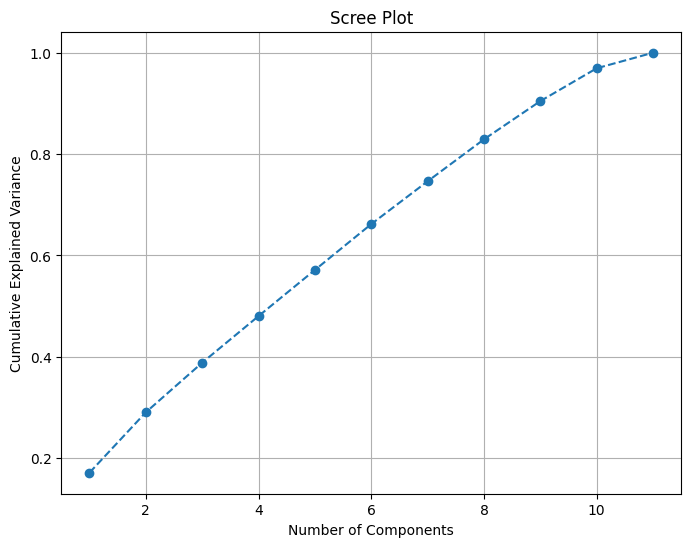

In [104]:
%matplotlib inline
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

In [105]:
threshold = 0.9
components_selected = np.where(cumulative_explained_variance >= threshold)[0][0] + 1

In [106]:
cumulative_explained_variance[components_selected - 1]

np.float64(0.9045746760867721)

In [107]:
# So to explain 90% of information we need at least 9 compnenets from the dataset
mlflow.set_experiment("PCA")
with mlflow.start_run(run_name="PCA"):

    mlflow.log_param("num_components", X_scaled.shape[1])  # Number of components
    mlflow.log_param("explained_variance_ratio", explained_variance_ratio[:10])  
    threshold = 0.9
    components_selected = np.where(cumulative_explained_variance >= threshold)[0][0] + 1  
    mlflow.log_param("num_components_selected", components_selected)

    mlflow.log_metric("cumulative_explained_variance", cumulative_explained_variance[components_selected - 1])

mlflow.end_run()

2024/12/19 23:23:33 INFO mlflow.tracking.fluent: Experiment with name 'PCA' does not exist. Creating a new experiment.


🏃 View run PCA at: https://dagshub.com/dushyanth9652narravula/Python_Final_Project.mlflow/#/experiments/8/runs/197afd0406d34017b0dfb667762c537b
🧪 View experiment at: https://dagshub.com/dushyanth9652narravula/Python_Final_Project.mlflow/#/experiments/8
